In [ ]:
#"I (We) certify that the code and data in this assignment were generated independently,
#using only the tools and resources defined in the course and that I (we) did not receive
#any external help, coaching or contributions during the production of this work.

In [2]:
#import tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#Upload datasets
df_penguins = pd.read_csv("datasets/penguins_lter.csv")


#Insert general data analysis
print('General data information')
print(df_penguins.describe())
#shape of data
print('Shape of data:')
print(df_penguins.shape)

General data information
       Sample Number  Culmen Length (mm)  Culmen Depth (mm)  \
count     344.000000          342.000000         342.000000   
mean       63.151163           43.921930          17.151170   
std        40.430199            5.459584           1.974793   
min         1.000000           32.100000          13.100000   
25%        29.000000           39.225000          15.600000   
50%        58.000000           44.450000          17.300000   
75%        95.250000           48.500000          18.700000   
max       152.000000           59.600000          21.500000   

       Flipper Length (mm)  Body Mass (g)  Delta 15 N (o/oo)  \
count           342.000000     342.000000         330.000000   
mean            200.915205    4201.754386           8.733382   
std              14.061714     801.954536           0.551770   
min             172.000000    2700.000000           7.632200   
25%             190.000000    3550.000000           8.299890   
50%             197.000

In [1]:
# "species" column - convert string values into category values
df_penguins["Species"]=df_penguins["Species"].astype("category")
# "island" column - convert string values into category values
df_penguins["Island"]=df_penguins["Island"].astype("category")
# "sex" column - convert string values into category values
df_penguins["Sex"]=df_penguins["Sex"].astype("category")
#Remove special characters that are not relevant for string values
df_penguins['Sex'] = df_penguins['Sex'].cat.set_categories(['MALE', 'FEMALE'])

#Remove all rows with NaN values for 'sex','bill length','bill depth','flipper length', and 'body mass' and reset index naming
df_penguins = df_penguins.dropna(subset=['Sex'])
df_penguins = df_penguins.dropna(subset=['Culmen Length (mm)'])
df_penguins = df_penguins.dropna(subset=['Culmen Depth (mm)'])
df_penguins = df_penguins.dropna(subset=['Flipper Length (mm)'])
df_penguins = df_penguins.dropna(subset=['Body Mass (g)'])
df_penguins = df_penguins.reset_index(drop=True)

#Normalize and rescale all numerical metrics between 0 and 1
bill_length = df_penguins["Culmen Length (mm)"]
min_bill_length = bill_length.min()
max_bill_length = bill_length.max()-min_bill_length
bill_length_norm = (bill_length-np.ones(len(bill_length))*min_bill_length)/max_bill_length

bill_depth = df_penguins["Culmen Depth (mm)"]
min_bill_depth = bill_depth.min()
max_bill_depth = bill_depth.max()-min_bill_depth
bill_depth_norm = (bill_depth-np.ones(len(bill_depth))*min_bill_depth)/max_bill_depth

flipper_length = df_penguins["Flipper Length (mm)"]
min_flipper_length = flipper_length.min()
max_flipper_length = flipper_length.max()-min_flipper_length
flipper_length_norm = (flipper_length-np.ones(len(flipper_length))*min_flipper_length)/max_flipper_length

body_mass = df_penguins["Body Mass (g)"]
min_body_mass = body_mass.min()
max_body_mass = body_mass.max()-min_body_mass
body_mass_norm = (body_mass-np.ones(len(body_mass))*min_body_mass)/max_body_mass

#Use binary classifiers for male/female
#Use bill length, bil depth, flipper length, and body mass as X inputs for Y output(sex)
X_source = pd.concat([bill_length_norm, bill_depth_norm, flipper_length_norm, body_mass_norm], axis=1)
X_source.insert(loc=0, column='ones',value=1) #Insert ones column for X0 in correlation with w0 bias
y_source = df_penguins["Sex"].to_frame()
cleanup_nums = {"Sex":{"FEMALE": 0, "MALE": 1}}
y_source = y_source.replace(cleanup_nums)

#Capture training values (80% of data set - training)
len_80_percent = round(len(y_source)*80/100)
X_train = X_source.head(len_80_percent)
y_train = y_source.head(len_80_percent)

#Capture testing values (20% of data set - testing)
X_test = X_source.tail(len(y_source)-len_80_percent)
X_test = X_test.reset_index(drop=True) #reset indexing to start at 0
y_test = y_source.tail(len(y_source)-len_80_percent)
y_test = y_test.reset_index(drop=True) #reset indexing to start at 0

class LogitRegression:
  def __init__(self, learning_rate, iteration_qty):
    self.learning_rate = learning_rate
    self.iteration_qty = iteration_qty

  def sigmoid(self, z):
  # Define a sigmoid function as
    return 1/(1+np.exp(-z))

  def cost(self, w_cost, x_cost, y_train_cost,n_cost):
  # Loss function for Logistic Regression can be defined as
    h = self.predict_val(w_cost, x_cost)
    val_cost = (1/n_cost)*((-y_train_cost*np.log(h))-((1-y_train_cost)*np.log(1-h)))
    val_cost = val_cost.item()
    return val_cost

  def predict_val(self, w_pred, x_pred):
    dot_prod = 0
    for i in range(len(x_pred)):
      dot_prod = dot_prod + w_pred[i]*x_pred[i]
    dot_prod = dot_prod.item()
    return self.sigmoid(dot_prod)

  def predict(self, w_predict, x_predict):
    val = self.predict_val(w_predict, x_predict)
    if val < 0.5:
      return 0
    else:
      return 1

  def delta(self, w_delta, x_delta, y_train_delta):
    delt = 0
    delt = self.predict_val(w_delta, x_delta) - y_train_delta
    return delt.item()

  def gradient_descent(self, w_grad, x_grad, y_train_grad, n_grad):
  # Define current prediction y_hat for logistic regression as 
    d = self.delta(w_grad, x_grad, y_train_grad)
    gd = (x_grad*d)/n_grad
    gd = gd.rename(index={"ones": "w0", "Culmen Length (mm)": "w1", "Culmen Depth (mm)" : "w2", "Flipper Length (mm)" : "w3", "Body Mass (g)": "w4"})
    return gd

  def check(self, y_guess, y_true):
  #Check if expected/estimated result is correct or not
    if y_guess == y_true:
      return 1
    else: 
      return 0

  # Takes as an input hyperparameters: learning rate and the number of iterations.
  def fit(self, X_training, y_training):
  #initialized weights
#Start with an initial bias of zero. Use random weights between 0 and 1 for everything else
    w_initial = {'w0':  0, 'w1':  np.random.uniform(0, 1), 'w2':  np.random.uniform(0, 1), 'w3':  np.random.uniform(0, 1), 'w4':  np.random.uniform(0, 1)}
    w = pd.Series(data=w_initial, index=['w0', 'w1', 'w2','w3','w4'])
    i = 0
    loss = np.zeros(self.iteration_qty)
    result = np.zeros(self.iteration_qty)
    n = len(y_training) #length of dataset
    N = len(X_training.columns) #length of X
    while i < self.iteration_qty:
      u = np.random.randint(0, n) #choose a random column number from the data set
      X_samp = X_training.loc[u,:] #call X sample for the iteration
      y_samp = y_training.loc[u,:] #call y sample for the iteration
      p = self.predict(w, X_samp) #predicted value
      y_samp_bool = np.squeeze(y_samp)
      result[i] = self.check(p,y_samp_bool) #check whether the predicted value is correct (0 is incorrect, 1 is correct)
      dW = self.gradient_descent(w, X_samp, y_samp,N) #calculate the gradient descent 
      loss[i] = self.cost(w, X_samp, y_samp,N) #calculate the loss
      w = w - dW*self.learning_rate #calculate the updated weights with the gradient descent
      i = i+1 
    self.w = w
    self.dW = dW
    self.loss = loss
  def test(self, X_testing, y_testing):
    i = 0
    n = len(y_testing) #length of dataset
    N = len(X_testing.columns) #length of X
    loss = np.zeros(n)
    result = np.zeros(n)
    fraction_correct = 0
    while i < n:
      X_samp = X_testing.loc[i,:] #call X sample for the iteration
      y_samp = y_testing.loc[i,:] #call y sample for the iteration
      p = self.predict(self.w, X_samp) #predicted value
      y_samp_bool = np.squeeze(y_samp)
      result[i] = self.check(p,y_samp_bool) #check whether the predicted value is correct (0 is incorrect, 1 is correct)
      loss[i] = self.cost(self.w, X_samp, y_samp, N) #calculate the loss
      i = i+1 
    self.loss_test = loss
    self.result = result
    fraction_correct = result.sum()/n
    self.percent_correct = round(fraction_correct*100,1)

#learning rate
learning_rate = 1
#number of iterations
iterations = 1000
model = LogitRegression(learning_rate, iterations)
model.fit(X_train, y_train)
model.test(X_test, y_test)
print('Model Accuracy (percent)')
print(model.percent_correct)
print('Model Weights')
print(model.w)

NameError: name 'df_penguins' is not defined

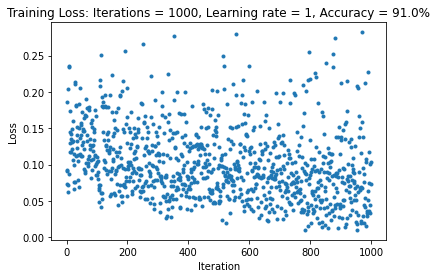

In [132]:
#Output the loss plot
plt.plot(model.loss, '.')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title('Training Loss: Iterations = {}, Learning rate = {}, Accuracy = {}%'.format(iterations,learning_rate,model.percent_correct))
plt.show()
